In [1]:
library('tidyverse')
library('ggrepel')
library('ggbeeswarm')
library('readxl')
library('limma')
library('edgeR')

org_opts <- options()

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.3.0      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
readxl::excel_sheets('./Initial Dataset.xlsx')

[1] "SegmentProperties"   "BioProbeCountMatrix"

In [3]:
count_matrix <-
    read_xlsx('./Initial Dataset.xlsx', sheet='BioProbeCountMatrix')

count_matrix %>%
    head

ProbeName,ProbeDisplayName,TargetName,HUGOSymbol,Accessions,GenomeBuild,GenomicPosition,AnalyteType,CodeClass,ProbePool,⋯,Obsidian Treat On state (NV21-3844+NV21-3845) | 008 | Immune,Obsidian Treat On state (NV21-3844+NV21-3845) | 008 | Tumor,Obsidian Treat On state (NV21-3844+NV21-3845) | 009 | Immune,Obsidian Treat On state (NV21-3844+NV21-3845) | 009 | Tumor,Obsidian Treat On state (NV21-3844+NV21-3845) | 010 | Immune,Obsidian Treat On state (NV21-3844+NV21-3845) | 010 | Tumor,Obsidian Treat On state (NV21-3844+NV21-3845) | 011 | Immune,Obsidian Treat On state (NV21-3844+NV21-3845) | 011 | Tumor,Obsidian Treat On state (NV21-3844+NV21-3845) | 012 | Immune,Obsidian Treat On state (NV21-3844+NV21-3845) | 012 | Tumor
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
45635,GAL_01,GAL,GAL,NM_015973.5,GRCh38.p13,chr11:68688852-68688901,RNA,Endogenous,01,⋯,1,31,6,13,4,26,10,26,1,21
44966,SOX8_01,SOX8,SOX8,NM_014587.5,GRCh38.p13,chr16:986546-986595,RNA,Endogenous,01,⋯,1,37,12,14,11,24,11,23,3,48
51991,MT1F_01,MT1F,MT1F,"NM_001301272.1,NM_005949.4",GRCh38.p13,chr16:56658006-56658053,RNA,Endogenous,01,⋯,1,51,19,18,13,35,23,31,6,42
44061,IFNA13_01,IFNA13,"IFNA13,IFNA1","NM_006900.4,NM_024013.3",GRCh38.p13,"chr9:21367715-21367764,chr9:21440751-21440800",RNA,Endogenous,01,⋯,2,22,10,16,3,19,13,23,2,21
37833,ZNF682_01,ZNF682,ZNF682,"XM_017027455.1,NM_033196.3,NM_001077349.1,XM_017027456.1",GRCh38.p13,chr19:20006017-20006066,RNA,Endogenous,01,⋯,1,32,10,11,6,22,5,19,3,36
46738,IGLL1_01,IGLL1,IGLL1,"NM_152855.3,NM_020070.4,NM_001369906.1",GRCh38.p13,chr22:23580046-23580080,RNA,Endogenous,01,⋯,1,20,6,7,4,19,8,17,1,21


In [4]:
sample_metadata <-
    tibble(
        `Sample`=
            count_matrix %>%
            select(ends_with(" Immune")) %>%
            colnames()
    ) %>%
    separate(`Sample`, c('group_name', 'region_no', 'compartment'), sep=' \\| ') %>%
    mutate(
        `sample_no`=if_else(
            parse_integer(`region_no`) < 7,
            '1',
            '2'
        ),
        `short_cond`=case_when(
            startsWith(`group_name`, 'Obsidian Treat Off') ~ 'off',
            startsWith(`group_name`, 'Obsidian Treat On') ~ 'on',
            startsWith(`group_name`, 'Conv Treat') ~ 'conv'
        )
    ) %>%
    relocate(`short_cond`, .after=`group_name`)

sample_metadata

group_name,short_cond,region_no,compartment,sample_no
<chr>,<chr>,<chr>,<chr>,<chr>
Obsidian Treat Off state (NV21-3843+NV21-3844),off,001,Immune,1
Obsidian Treat Off state (NV21-3843+NV21-3844),off,002,Immune,1
Obsidian Treat Off state (NV21-3843+NV21-3844),off,003,Immune,1
Obsidian Treat Off state (NV21-3843+NV21-3844),off,004,Immune,1
Obsidian Treat Off state (NV21-3843+NV21-3844),off,005,Immune,1
Obsidian Treat Off state (NV21-3843+NV21-3844),off,006,Immune,1
Obsidian Treat Off state (NV21-3843+NV21-3844),off,007,Immune,2
Obsidian Treat Off state (NV21-3843+NV21-3844),off,008,Immune,2
Obsidian Treat Off state (NV21-3843+NV21-3844),off,009,Immune,2


In [5]:
tumor_matrix <-
    count_matrix %>%
    select(`hugo_symbol`=`HUGOSymbol`, ends_with(" Immune")) %>%
    drop_na(`hugo_symbol`) %>%
    select(-starts_with('Obsidian Treat Off'))

gene_names <- tumor_matrix %>% pull(`hugo_symbol`)
tumor_matrix <- as.matrix(tumor_matrix %>% select(-`hugo_symbol`))
rownames(tumor_matrix) <- gene_names

tumor_matrix %>%
    head()

,Conv Treat (NV21-3841+NV21-3842) | 001 | Immune,Conv Treat (NV21-3841+NV21-3842) | 002 | Immune,Conv Treat (NV21-3841+NV21-3842) | 003 | Immune,Conv Treat (NV21-3841+NV21-3842) | 004 | Immune,Conv Treat (NV21-3841+NV21-3842) | 005 | Immune,Conv Treat (NV21-3841+NV21-3842) | 006 | Immune,Conv Treat (NV21-3841+NV21-3842) | 007 | Immune,Conv Treat (NV21-3841+NV21-3842) | 008 | Immune,Conv Treat (NV21-3841+NV21-3842) | 009 | Immune,Conv Treat (NV21-3841+NV21-3842) | 010 | Immune,⋯,Obsidian Treat On state (NV21-3844+NV21-3845) | 003 | Immune,Obsidian Treat On state (NV21-3844+NV21-3845) | 004 | Immune,Obsidian Treat On state (NV21-3844+NV21-3845) | 005 | Immune,Obsidian Treat On state (NV21-3844+NV21-3845) | 006 | Immune,Obsidian Treat On state (NV21-3844+NV21-3845) | 007 | Immune,Obsidian Treat On state (NV21-3844+NV21-3845) | 008 | Immune,Obsidian Treat On state (NV21-3844+NV21-3845) | 009 | Immune,Obsidian Treat On state (NV21-3844+NV21-3845) | 010 | Immune,Obsidian Treat On state (NV21-3844+NV21-3845) | 011 | Immune,Obsidian Treat On state (NV21-3844+NV21-3845) | 012 | Immune
GAL,3,2,2,5,1,1,2,1,4,5,⋯,1,2,5,1,2,1,6,4,10,1
SOX8,9,1,7,7,1,4,4,4,4,5,⋯,2,3,2,5,3,1,12,11,11,3
MT1F,8,5,4,11,6,10,2,6,5,6,⋯,4,6,5,11,5,1,19,13,23,6
"IFNA13,IFNA1",7,1,1,5,2,3,2,1,1,7,⋯,4,3,7,8,2,2,10,3,13,2
ZNF682,2,1,2,7,2,5,1,1,2,7,⋯,3,4,1,3,1,1,10,6,5,3
IGLL1,4,5,5,5,4,1,6,1,7,4,⋯,2,6,2,5,2,1,6,4,8,1


In [6]:
exp_model <-
    sample_metadata %>%
    filter(`short_cond` %in% c('on', 'conv')) %>%
    model.matrix(data=., ~`short_cond`)

exp_model

,(Intercept),short_condon
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0
10,1,0


In [7]:
dge <-
    DGEList(tumor_matrix) %>%
    calcNormFactors()

keep <- filterByExpr(dge, exp_model)
dge <- dge[keep,, keep.lib.sizes=FALSE]
vdge <- voom(dge, exp_model)
all_fit <- lmFit(vdge, exp_model) %>% eBayes

In [8]:
all_table <-
    topTable(all_fit, adjust.method='bonferroni', n=nrow(tumor_matrix), sort.by='p') %>%
    rownames_to_column(var='gene') %>%
    as_tibble()

all_table %>%
    head(50)

Removing intercept from test coefficients



gene,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RPLP1,-1.1494125,11.632020,-18.783520,1.858395e-21,5.136602e-18,38.66369
PRMT8,2.1317056,10.432895,17.136174,4.923798e-20,1.360938e-16,35.51417
C4orf46,2.6404294,8.222918,16.177620,3.712382e-19,1.026102e-15,33.46565
GNLY,5.2776765,9.661867,16.035278,5.049323e-19,1.395633e-15,33.21964
ZNF587,2.7057434,7.997243,15.327125,2.404469e-18,6.645952e-15,31.61338
XRCC2,2.6419876,7.829680,14.533559,1.471374e-17,4.066876e-14,29.83756
IL2RB,2.4363161,8.143477,14.403547,1.992732e-17,5.507912e-14,29.57462
CCL5,2.6016230,9.603052,13.923839,6.203102e-17,1.714537e-13,28.43386
EOMES,-2.4552382,7.363390,-13.782039,8.720996e-17,2.410483e-13,28.11589


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_label_repel()`).”


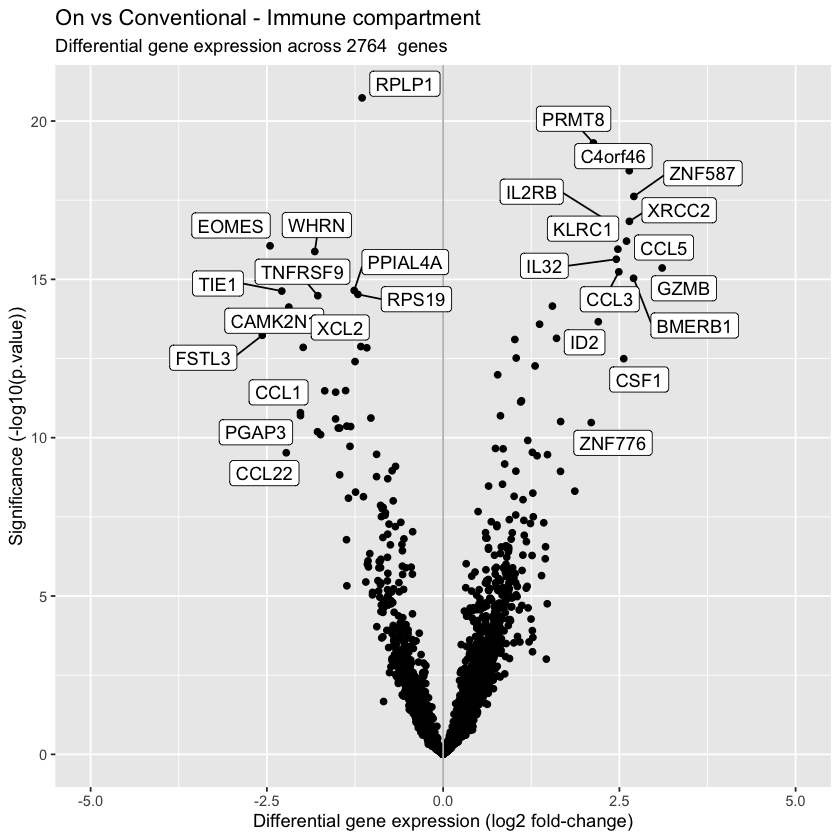

In [9]:
all_table %>%
    mutate(
        `label`=case_when(
            abs(`logFC`) >= 2 ~ str_replace_all(`gene`, ',.*', ''),
            `logFC` < -1 & -log10(`P.Value`) > 13 ~ str_replace_all(`gene`, ',.*', ''),
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf) +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='On vs Conventional - Immune compartment',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes')
        ) +
        xlim(-5, 5)


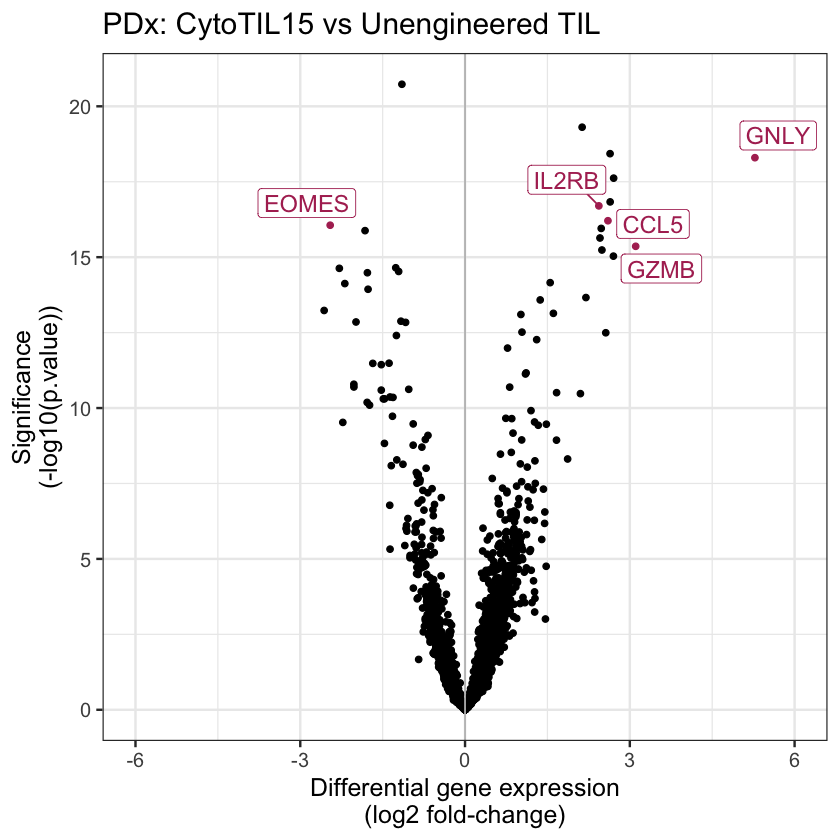

In [10]:
dge_gois <- c('KLRC1', 'GNLY', 'CCL5', 'GZMB', 'EOMES', 'TCF1', 'IL2RB')

all_table %>%
    mutate(
        `label`=case_when(
            `gene` %in% dge_gois ~ `gene`,
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`), color=`label` != '')) +
        geom_point() +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf, size=5) +
        labs(
            x='Differential gene expression\n(log2 fold-change)',
            y='Significance\n(-log10(p.value))',
            title='PDx: CytoTIL15 vs Unengineered TIL'
        ) +
        xlim(-6, 6) +
        scale_color_manual(values=c('black', 'maroon')) +
        theme_bw(base_size = 15) +
        theme(legend.position='none')


In [11]:
all_table %>%
    write_csv('dge-immune-on_vs_conv.csv')